Copyright (c) 2020 Martin Holle. Alle Rechte vorbehalten. Lizensiert unter der MIT-Lizenz.


# Covid-19 Statistics Aachen: Datenvisualisierung

Die im vorherigen Schritt ermittelten Kennzahlen werden zunächst aus dem zur Zwischenspeicherung verwendeten Excel-Sheet eingelesen. Anschließend werden die Kennzahlen durch insgesamt 4 Diagramme visualisiert:

**1. Diagramm: Covid-19-Fälle in der Städteregion Aachen**<br/>
Für die Städteregion Aachen die aktiven Fälle und die Summe der Genesenen und Todesfälle darstellen.

**2. Diagramm: Änderung aktiver Fälle**<br/>
Für die Städteregion Aachen die Änderung der aktiven Fälle (absolut und prozentual, pro Tag und gemittelt) visualisieren.

**3. Diagramm: Neue Fälle / Genesene / Todesfälle**<br/>
Für die Städteregion Aachen  die gemittelten Werte neuer Fälle, neuer Genesener und neuer Todesfälle darstellen.

**4. Diagramm: Neuinfektionen in den letzten 7 Tagen pro 100.000 Einwohner**<br/>
Für die Städteregion und die Stadt Aachen die Summe der Neuinfektionen in den letzten 7 Tagen bezogen auf 100.000 Einwohner, die sog. „7-Tage-Inzidenz“, darstellen.

## Benötigte Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas as pd

import logging
import configparser
import os

# Konfiguration einlesen
config = configparser.ConfigParser(interpolation=None)
config.read('config.ini')

# Konfiguration des Loggings
fhandler = logging.FileHandler(filename=config['Logging']['LogFileName'], mode='a')
formatter = logging.Formatter(config['Logging']['LogFormat'])
fhandler.setFormatter(formatter)

# Logger instanzieren
log = logging.getLogger("visualisierung")
log.addHandler(fhandler)
log.setLevel(logging.INFO)

## Grafikausgabe konfigurieren

In [2]:
# Konfiguration einlesen
config = configparser.ConfigParser()
config.read('config.ini')

# Intervall (in Tagen) für die Glättung der Kurven
Glättungsintervall = int(config['Kennzahlen']['Glaettung.Intervall'])

# Ordner für die Speicherung der Grafik- und yaml-Dateien
output_folder=config['Visualisierung']['OutputFolder']

# Vordefinierte Style, der benutzt werden soll
plt.style.use(config['Visualisierung']['PlotStyle'])

# Maße und Auflösung
fig_dpi = int(config['Visualisierung']['Figure.DPI'])
fig_width = int(config['Visualisierung']['Figure.Width'])
fig_height = int(config['Visualisierung']['Figure.Height'])

# Grundeinstellungen für das Diagramm-Layout
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.titlepad'] = 10.0
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.borderpad'] = 1
mpl.rcParams['legend.borderaxespad'] = 1.5
mpl.rcParams['figure.figsize'] = fig_width, fig_height
mpl.rcParams['figure.dpi'] = fig_dpi
mpl.rcParams['savefig.dpi'] = fig_dpi
mpl.rcParams['savefig.bbox'] = 'tight'

# In bestimmten Diagrammen benutzte Farben (Maps)
color_map_rgb = [ "#0000dd", "#00dd00", "#dd0000" ]
color_map_named = [ "tab:blue", "tab:green", "tab:red" ]

## Vorverarbeitete Daten aus Excel-Datei einlesen

In [3]:
# Zwischenergebnisse aus Excel-Sheet einlesen
c19_cases = pd.read_excel(config['Kennzahlen']['FileName'], 
                          sheet_name=config['Kennzahlen']['SheetName'],
                          index_col=0,
                          parse_dates=[0])

## Hilfsfunktionen

In [4]:
def create_meta_file(filename: str, meta: {}, add_date: bool=False):
    """
    Create file with meta data in yml format.
    
    Parameters
    ----------
    filename : str
        File name for meta data file
    meta : {}
        Dictionary with meta data
    
    Returns
    -------
    None
    """
    log.info("Meta data file created: {0}".format(filename))
    
    if add_date:
        pass # TODO: Automatisches Hinzufügen des aktuellen Datums hinzufügen
    
    with open(filename, "w") as file:
        for name, value in meta.items():
            file.write("{0}: {1}\n----\n".format(name, value))

## 1. Diagramm: Covid-19-Fälle in der Städteregion Aachen

Für die Städteregion Aachen (nur dafür liegen alle benötigten Rohdaten vor), werden die aktiven Fälle und die Summe der Genesenen und Todesfälle dargestellt:

- Eine X-Achse: Zeitachse
- Als Y-Achse der gestapelte Verlauf der absoluten Anzahl kummulierter Fälle (von unten nach oben):
    - Aktive Fälle
    - Summe genesen
    - Summe Todesfälle
- Verwendung `df.plot.area()`: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.area.html

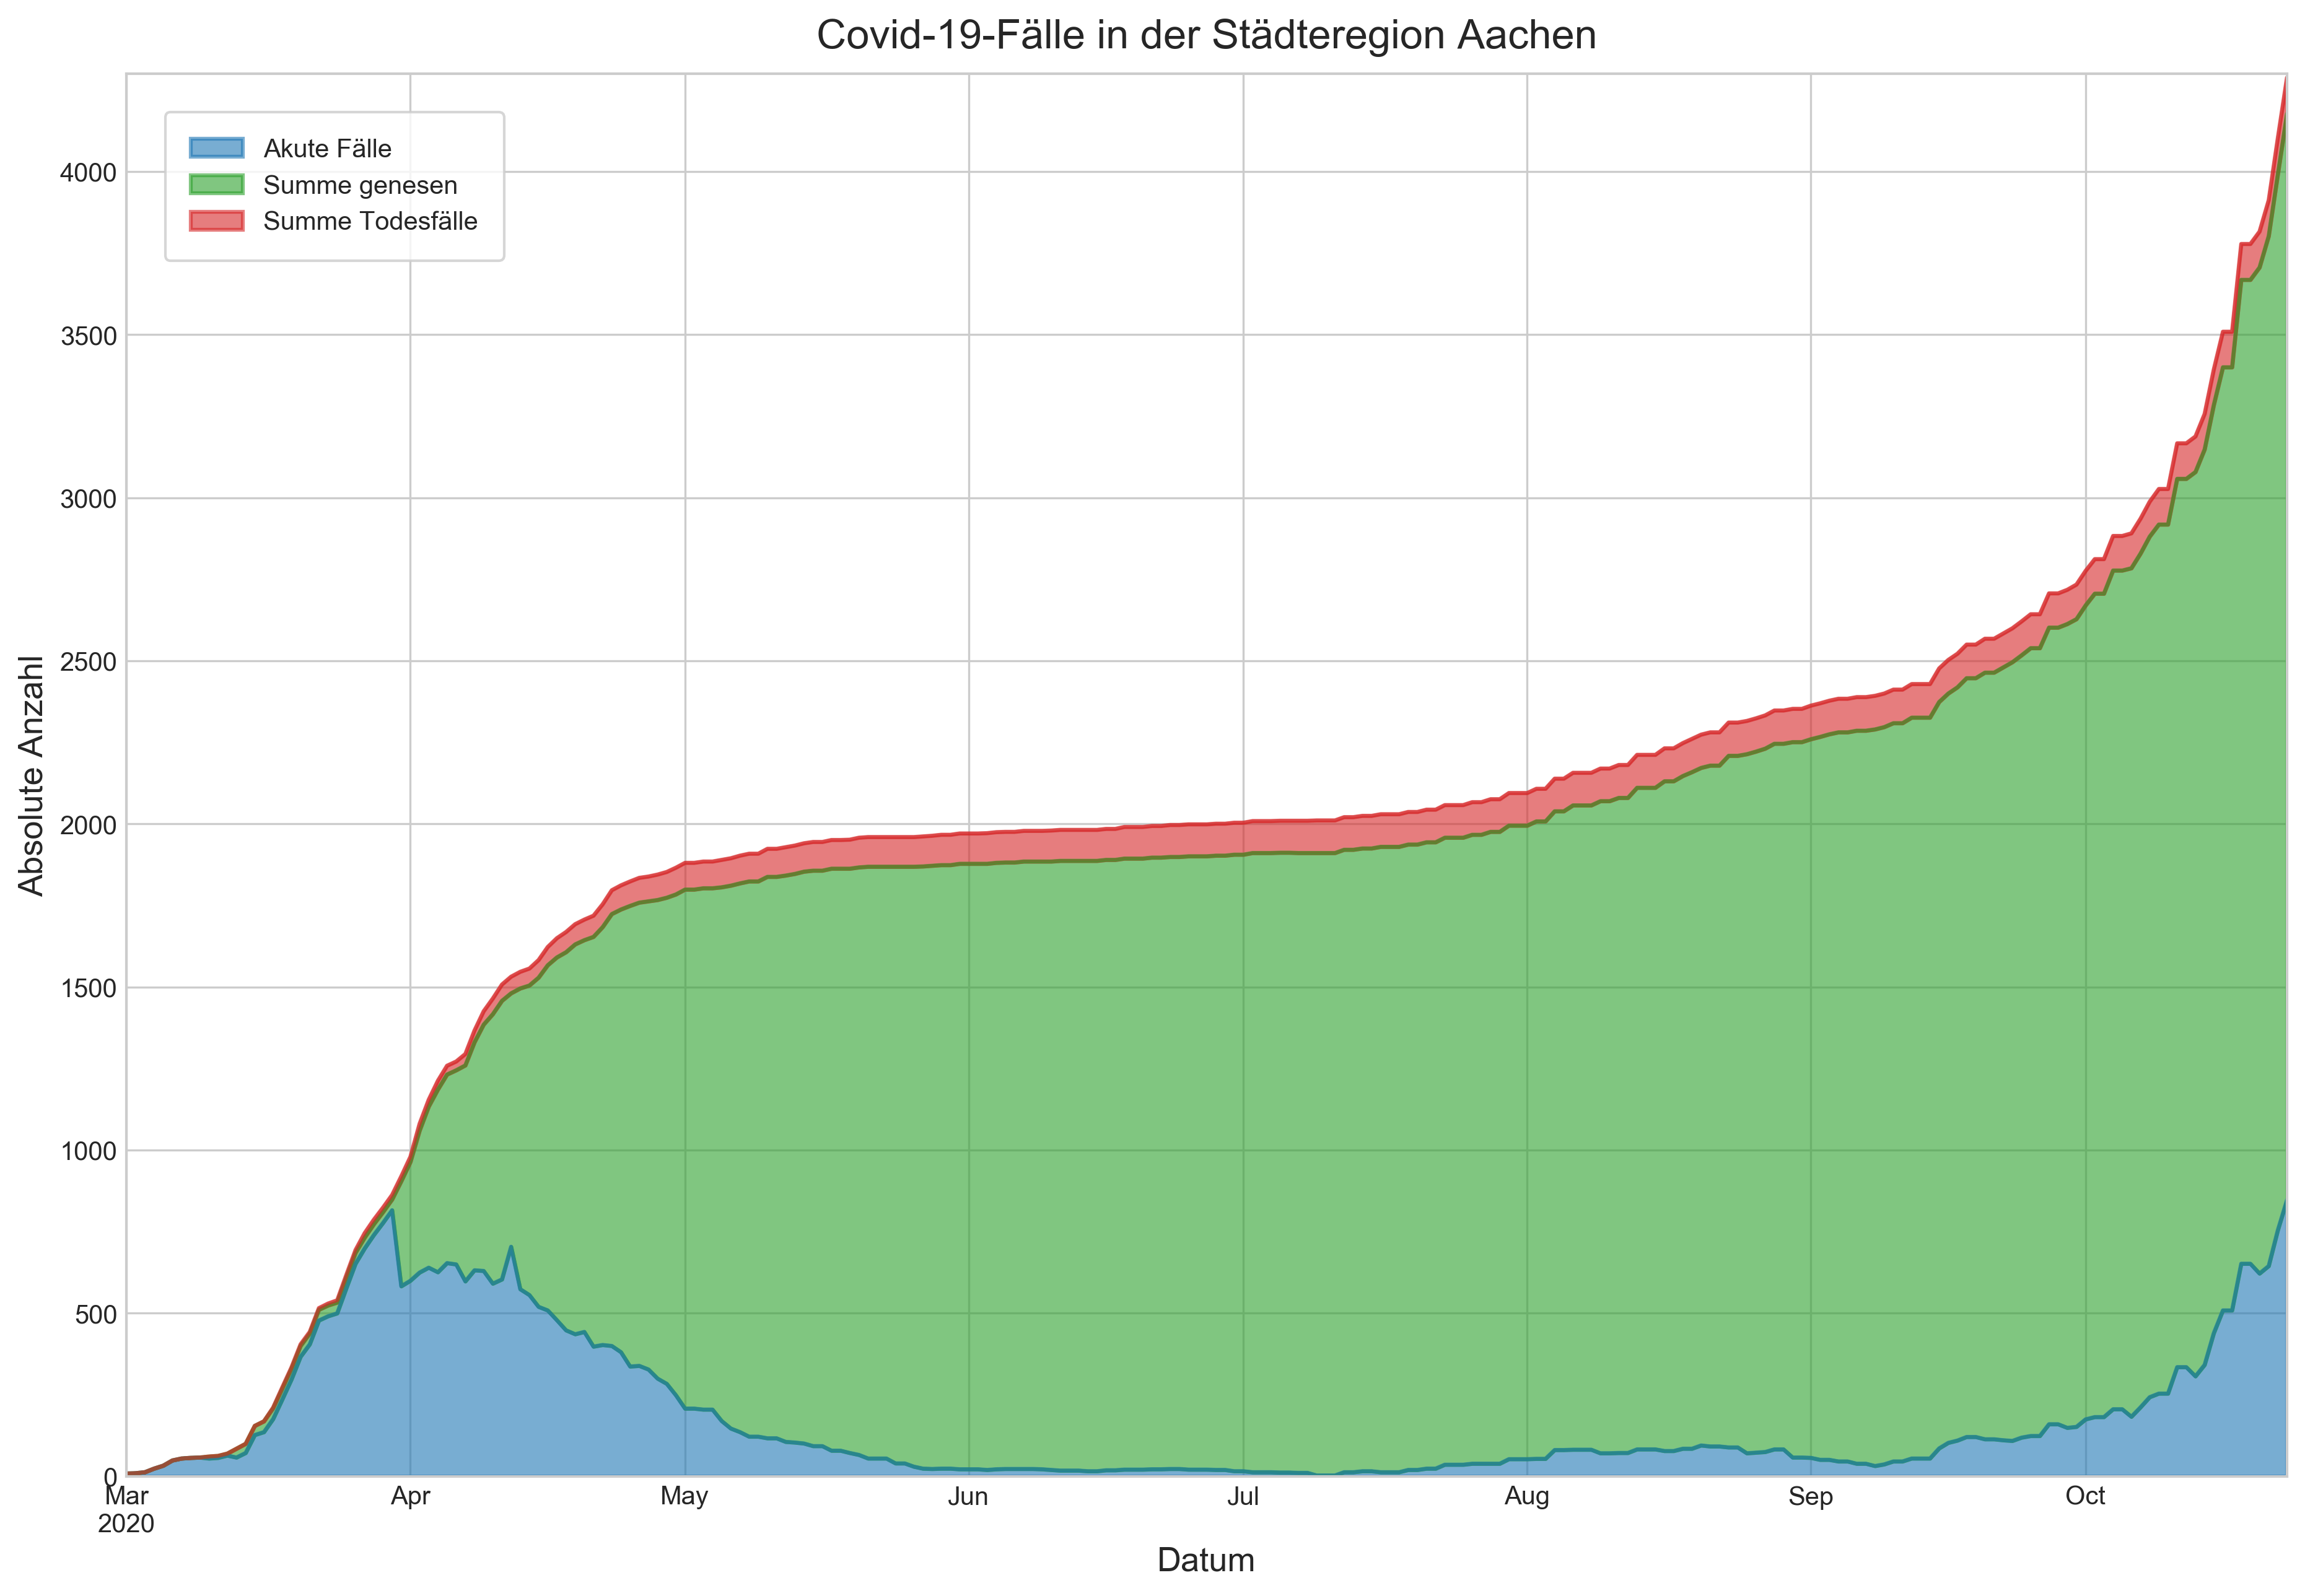

In [5]:
title = 'Covid-19-Fälle in der Städteregion Aachen'

ymax = ((c19_cases['Akute Fälle'] + c19_cases['Summe genesen'] + c19_cases['Summe Todesfälle']).max() // 50 + 1) * 50  

fig = plt.figure()
axes = fig.add_subplot(1,1,1)

ax1 = c19_cases[['Akute Fälle', 'Summe genesen', 'Summe Todesfälle']].plot.area(ax=axes, alpha=0.6, linewidth=1.5, color=color_map_named)

ax1.set_ylim(0, ymax)
ax1.set_xlim(c19_cases.index[0], c19_cases.index[-1])
ax1.set_ylabel('Absolute Anzahl')

axes.set_title(title)
axes.grid(b=True, which='major', axis='both')
axes.legend(loc='upper left')
axes.set_xlabel('Datum')

fig.savefig(os.path.join(output_folder, 'c19-kennzahlen-ac-1.jpg'))
file_meta = { "title" : title, "caption": title }
create_meta_file(os.path.join(output_folder, 'c19-kennzahlen-ac-1.jpg.txt'), file_meta)

## 2. Diagramm: Änderung aktiver Fälle

Für die Städteregion Aachen (nur dafür liegen alle benötigten Rohdaten vor) wird die Änderung der aktiven Fälle, absolut und prozentual, pro Tag und gemittelt, visualisiert:

- Eine X-Achse: Zeitachse
- Als Y-Achsen:
    - Achse 1 (links): Änderung der Anzahl aktiver Fälle in absoluten Zahlen (pro Tag und gemittelt)
    - Achse 2 (rechts): Änderung der Anzahl der aktiven Fälle in Prozent (pro Tag und gemittelt)
- Verwendung `df.plot.line()`: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.line.html

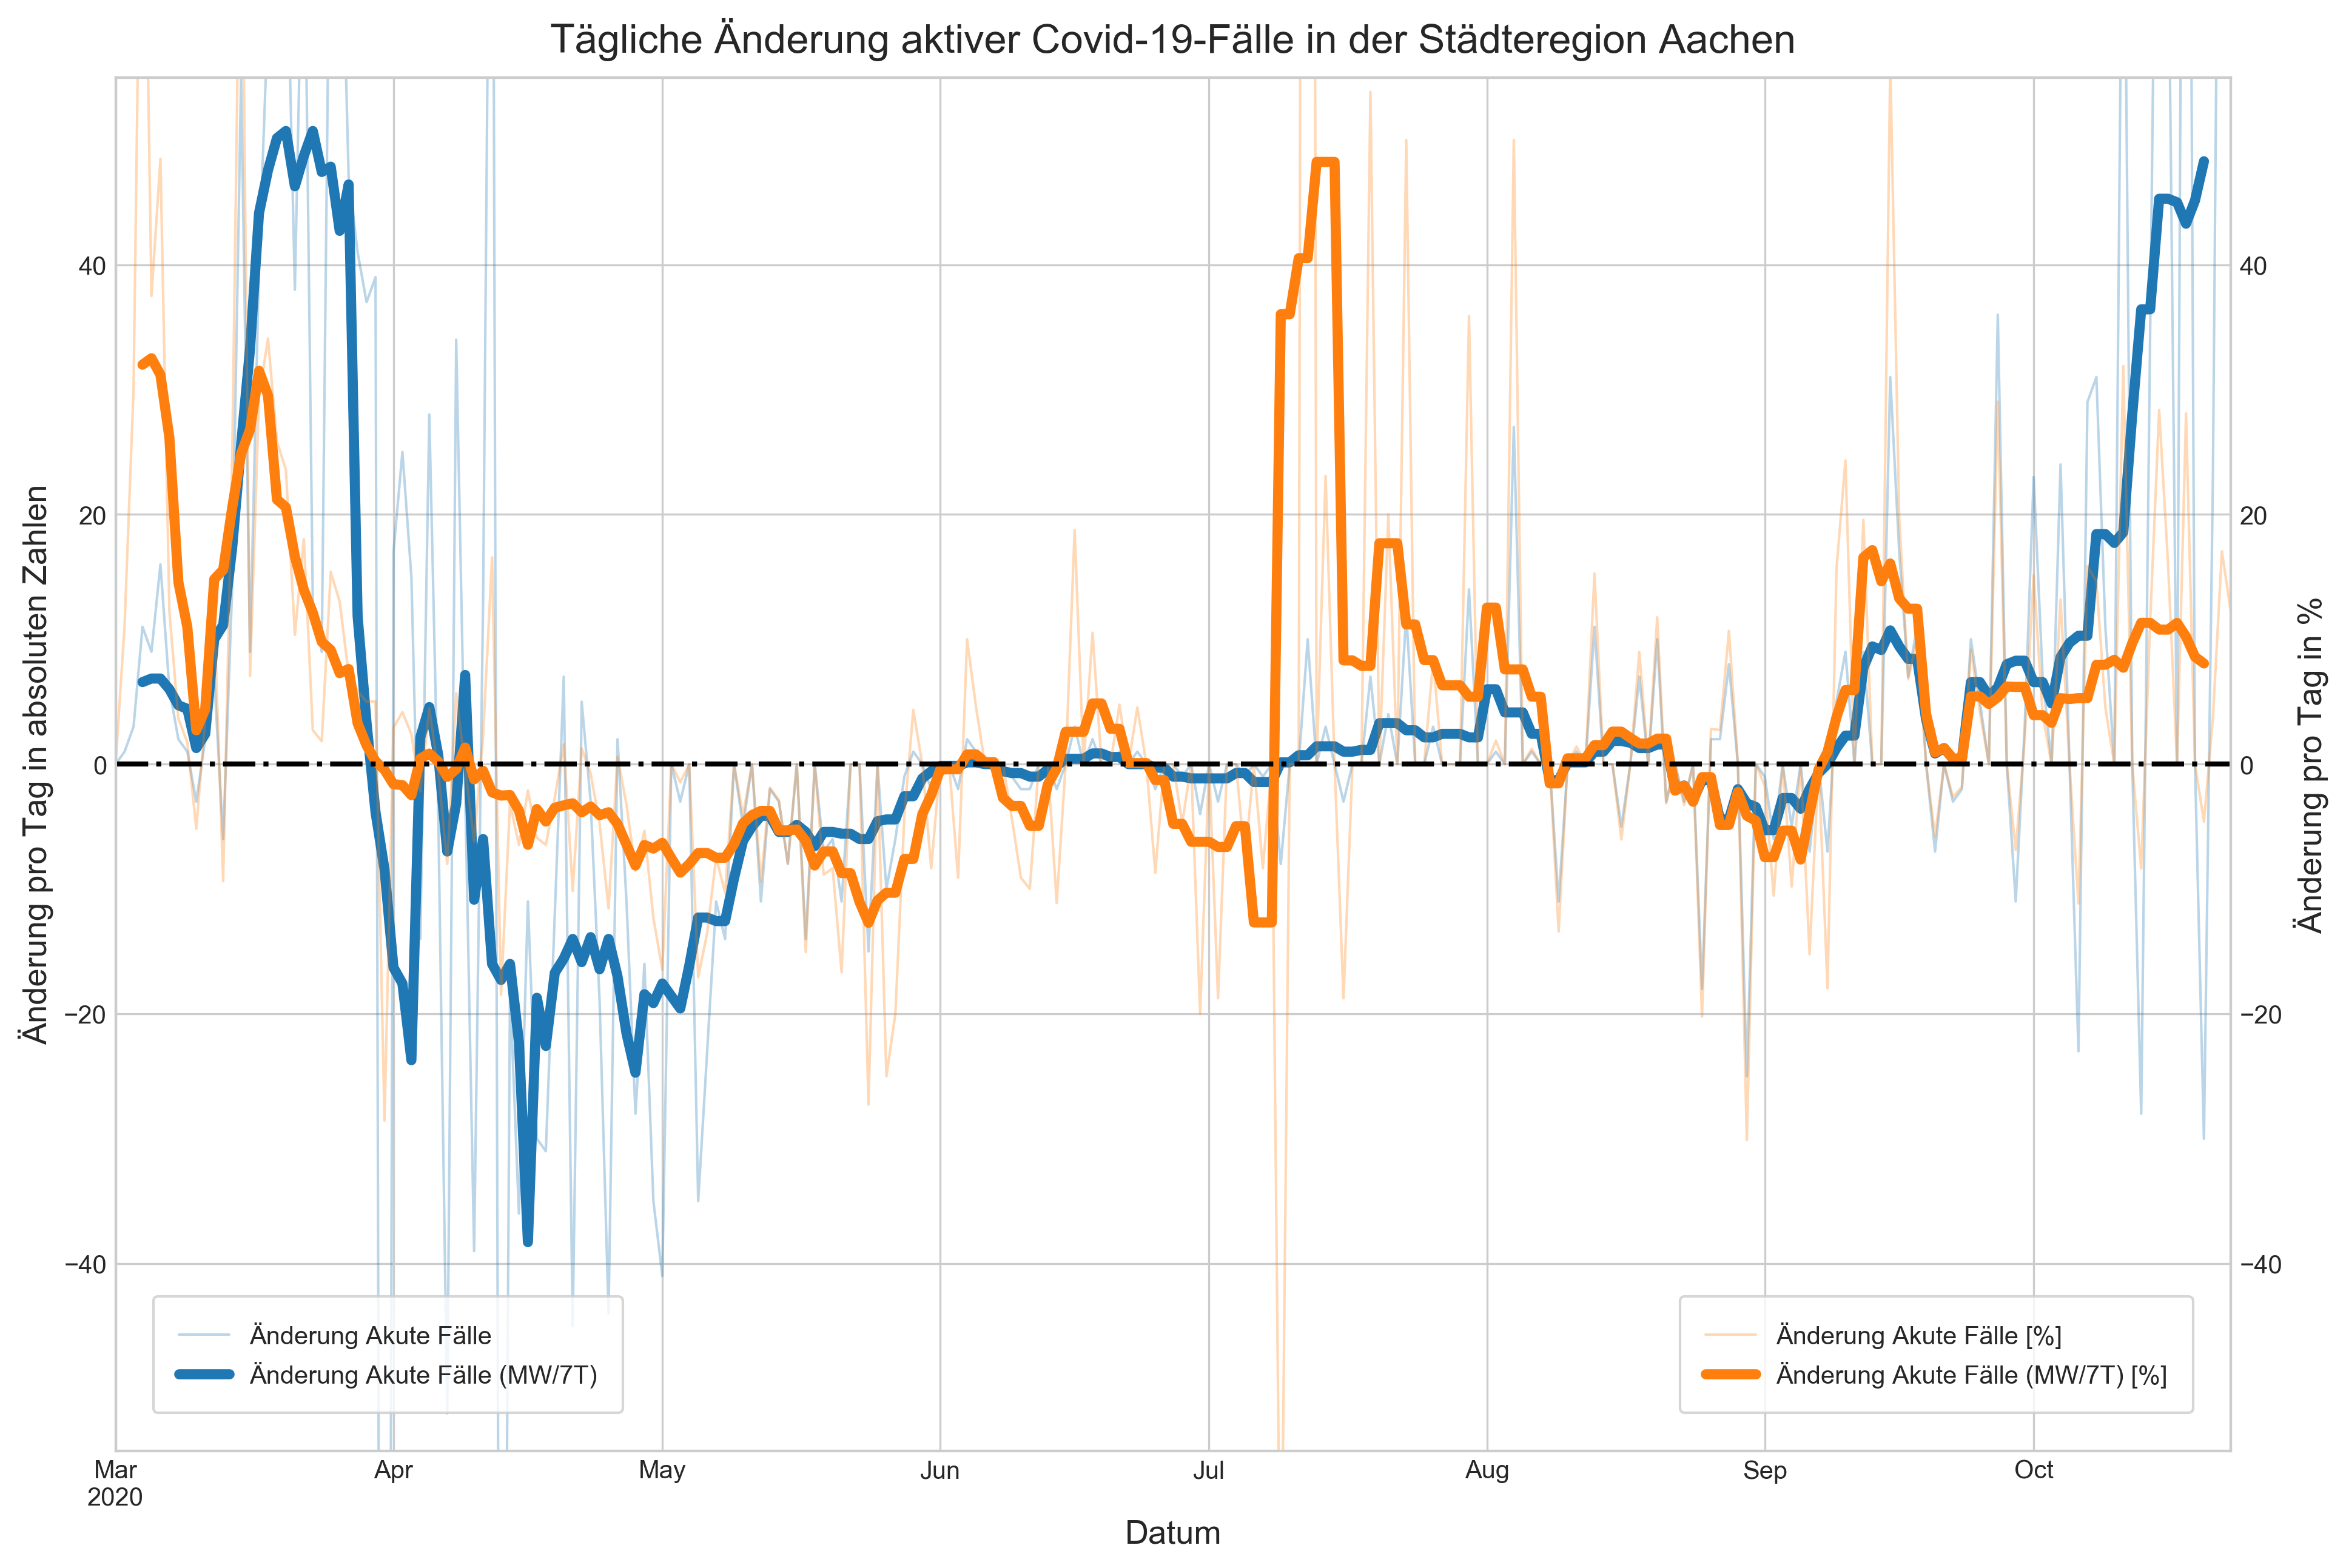

In [6]:
title = 'Tägliche Änderung aktiver Covid-19-Fälle in der Städteregion Aachen'

columns = [
    'Änderung Akute Fälle',
    'Änderung Akute Fälle (MW/{0}T)'.format(str(Glättungsintervall)),
    'Änderung Akute Fälle [%]',
    'Änderung Akute Fälle (MW/{0}T) [%]'.format(str(Glättungsintervall)) 
]

fig = plt.figure()
axes = fig.add_subplot(1,1,1)

# Berechnung Y-Aachsenskalierung
ymin = (c19_cases[columns[1]].min() // 5 - 1) * 5  
ymax = (c19_cases[columns[1]].max() // 5 + 1) * 5
absmax = max(abs(ymin), abs(ymax))
if absmax < 50:
    absmax = 50
ymin, ymax = -absmax, +absmax

# 1. Achse
ax1 = c19_cases[columns[0]].plot.line(ax=axes, style='-', linewidth=1, color='tab:blue', alpha=0.3)
c19_cases[columns[1]].plot.line(ax=ax1, style='-', linewidth=4, color='tab:blue')

ax1.set_ylim(ymin, ymax)
ax1.set_xlim(c19_cases.index[0], c19_cases.index[-1])
ax1.set_ylabel('Änderung pro Tag in absoluten Zahlen')

# 2. Achse
ax2 = c19_cases[columns[2]].plot.line(ax=axes, secondary_y=True, style='-', linewidth=1, color='tab:orange', alpha=0.3)
c19_cases[columns[3]].plot.line(ax=ax2, secondary_y=True, style='-', linewidth=4, color='tab:orange')

ax2.set_ylim(ymin, ymax)
ax2.set_xlim(c19_cases.index[0], c19_cases.index[-1])
ax2.set_ylabel('Änderung pro Tag in %')
ax2.axhline(y=0, ls='-.', color='black', linewidth=2)

ax1.legend(columns[0:2], loc='lower left')
ax2.legend(columns[2:4], loc='lower right')

axes.set_title(title)
axes.set_xlabel('Datum')
axes.grid(b=True, which='major', axis='both')

fig.savefig(os.path.join(output_folder, 'c19-kennzahlen-ac-2.jpg'))
file_meta = { "title" : title, "caption": title }
create_meta_file(os.path.join(output_folder, 'c19-kennzahlen-ac-2.jpg.txt'), file_meta)

## 3. Diagramm: Neue Fälle / Genesene / Todesfälle

Für die Städteregion Aachen (nur dafür liegen alle benötigten Rohdaten vor) werden die gemittelten Werte neuer Fälle, neuer Genesener und neuer Todesfälle visualisiert (die tagesaktuellen Werte schwanken sehr stark und sind wenig aussagekräftig):

- Eine X-Achse: Zeitachse
- Zwei Y-Achsen:
    - Achse 1 (links): Absolute Anzahl neuer Fälle und wieder Genesener
    - Achse 2 (rechts): Absolute Anzahl neuer Todesfälle

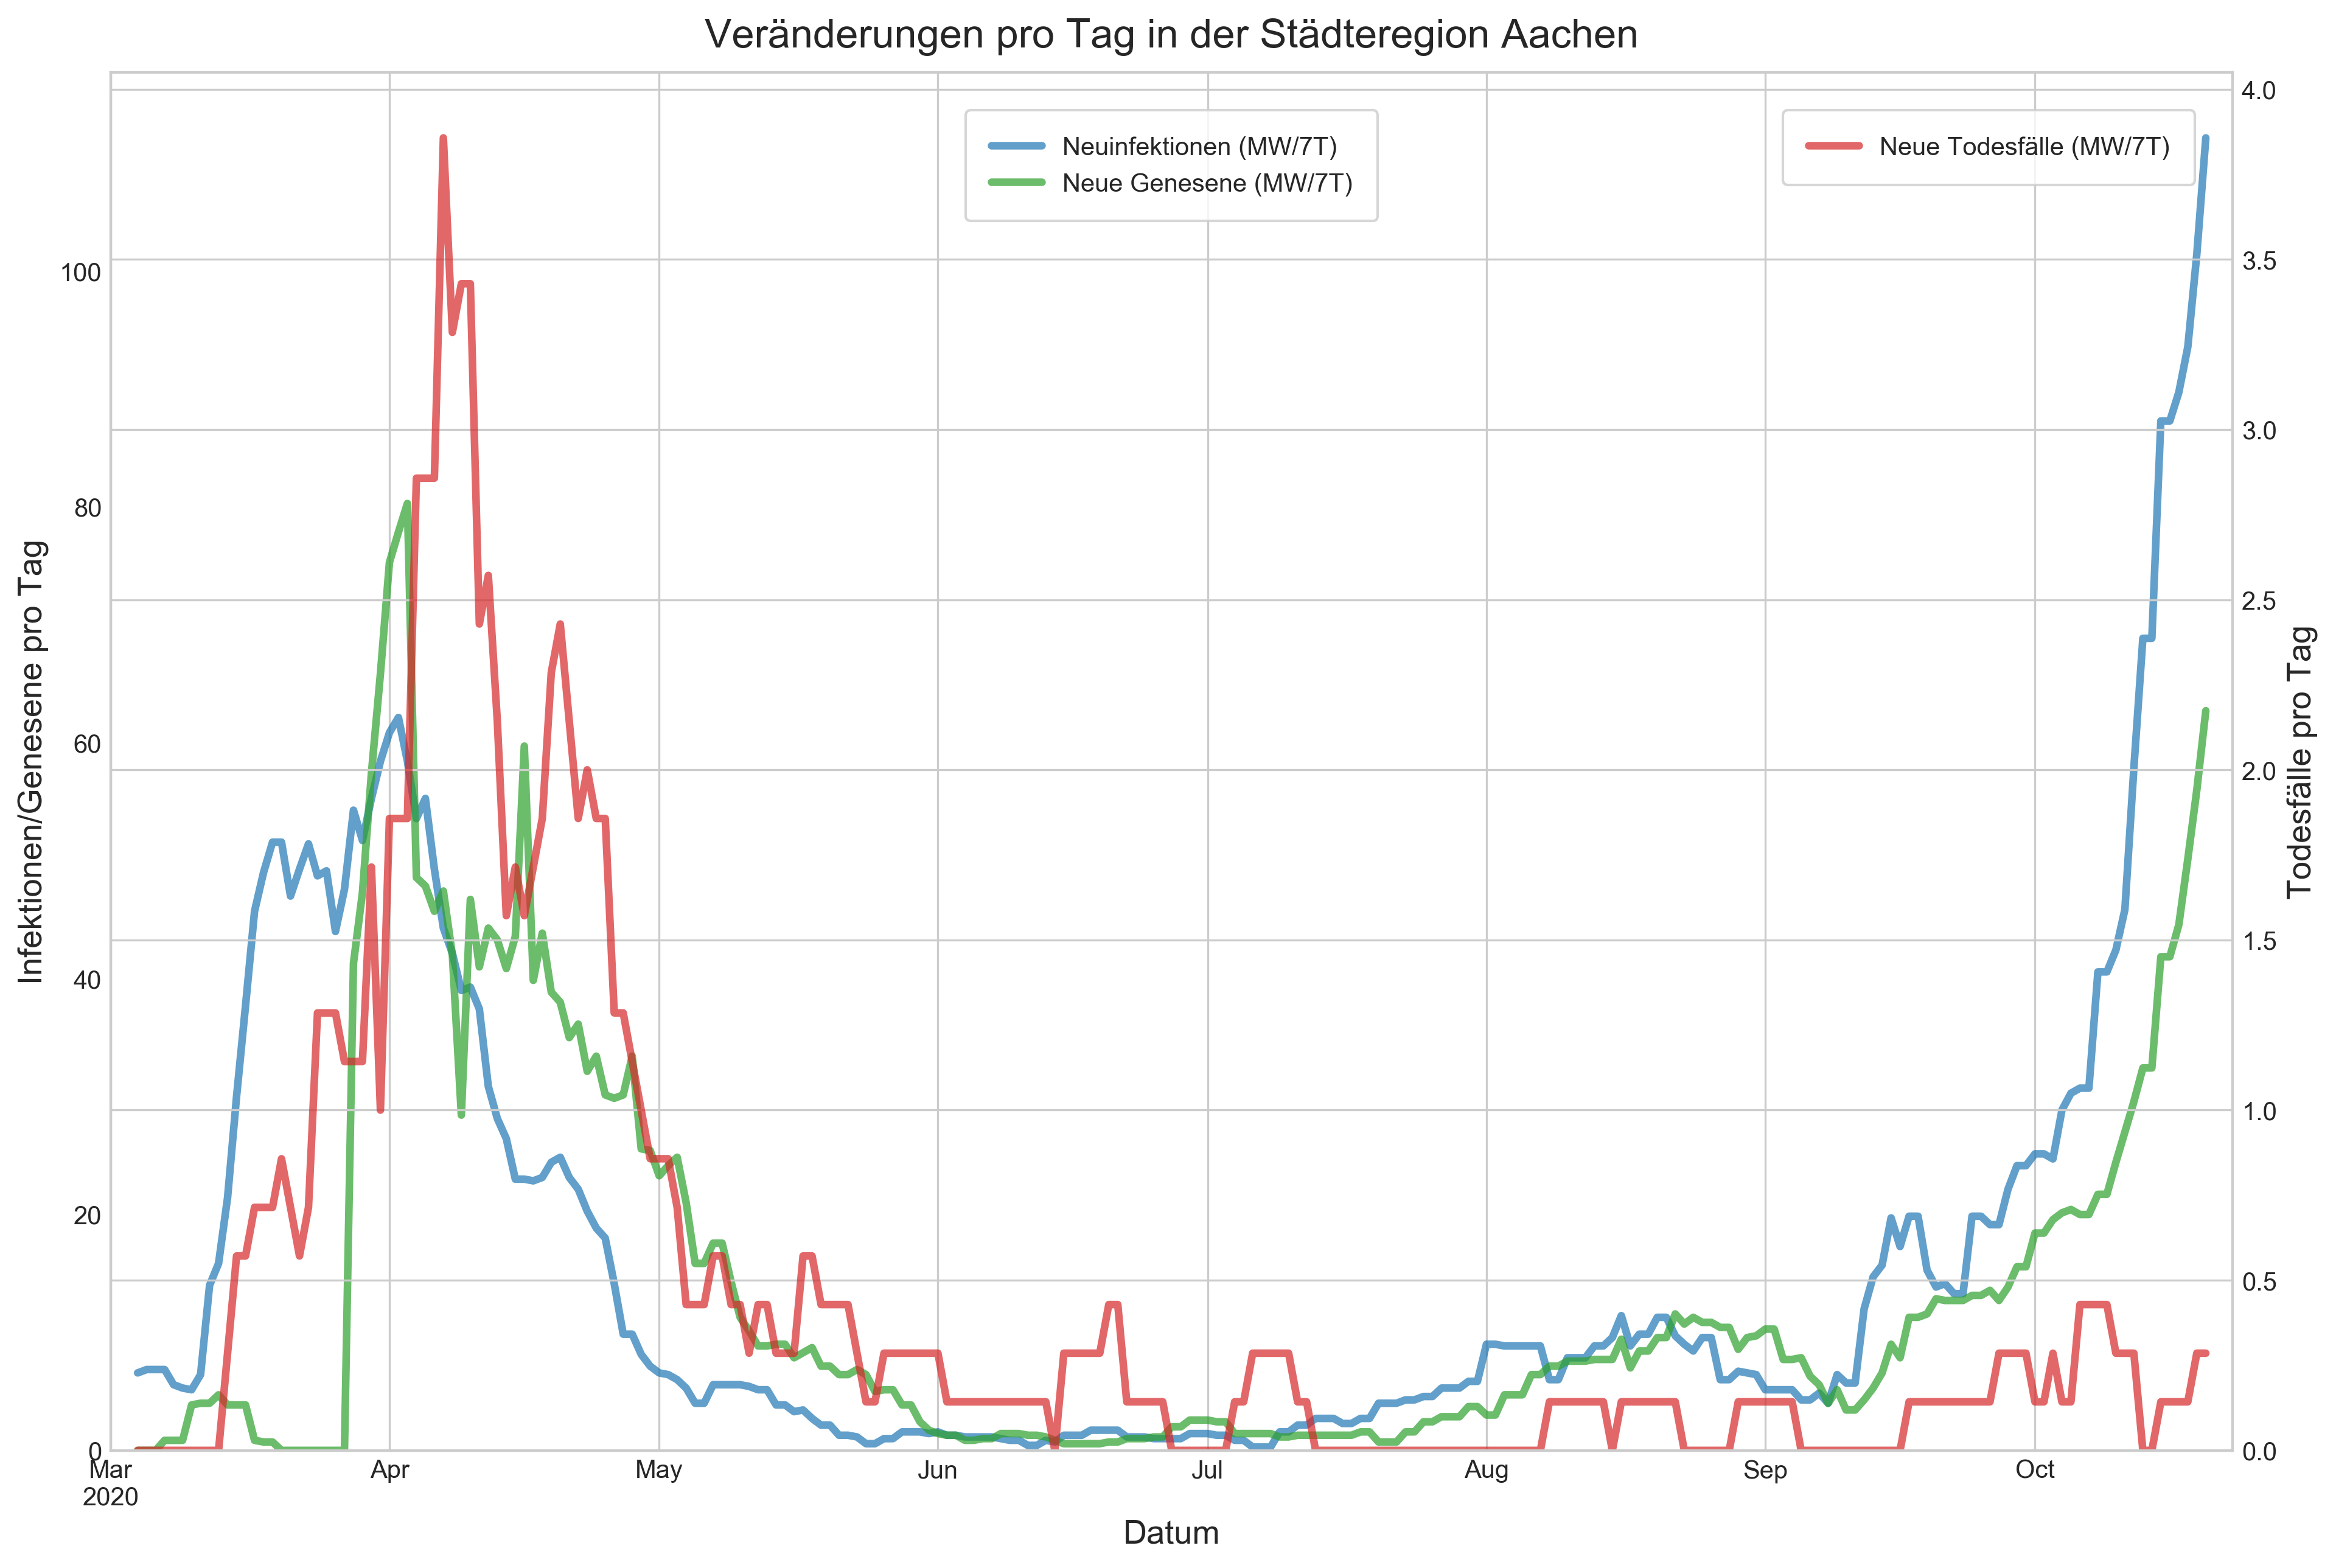

In [7]:
title = 'Veränderungen pro Tag in der Städteregion Aachen'

fig = plt.figure()
axes = fig.add_subplot(1,1,1)

# 1. Achse
ax1 = c19_cases[['Neuinfektionen (MW/{0}T)'.format(str(Glättungsintervall)), 'Neue Genesene (MW/{0}T)'.format(str(Glättungsintervall))]].plot.line(ax=axes, linewidth=3, alpha=0.7, color=color_map_named[:2])

ax1.set_ylim(0,)
ax1.set_xlim(c19_cases.index[0], c19_cases.index[-1])
ax1.set_ylabel('Infektionen/Genesene pro Tag')

# 2. Achse
ax2 = c19_cases[['Neue Todesfälle (MW/{0}T)'.format(str(Glättungsintervall))]].plot.line(ax=axes, secondary_y=True, linewidth=3, alpha=0.7, color=color_map_named[2])

ax2.set_ylim(0,)
ax2.set_xlim(c19_cases.index[0], c19_cases.index[-1])
ax2.set_ylabel('Todesfälle pro Tag')

axes.set_title(title)
axes.set_xlabel('Datum', fontsize=13)
axes.grid(b=True, which='major', axis='x')

ax1.legend(loc='upper center')
ax2.legend(loc='upper right')

fig.savefig(os.path.join(output_folder, 'c19-kennzahlen-ac-3.jpg'))
file_meta = { "title" : title, "caption": title }
create_meta_file(os.path.join(output_folder, 'c19-kennzahlen-ac-3.jpg.txt'), file_meta)

## 4. Diagramm: 7-Tage-Inzidenz

Für die Städteregion und die Stadt Aachen wird die Summe der Neuinfektionen in den letzten 7 Tagen bezogen auf 100.000 Einwohner, die sog. „_7-Tage-Inzidenz_“ dargestellt. Der obere Grenzwert, ab dem neue Maßnahmen ergriffen werden sollen, liegt dafür bei 50 Neuinfektionen in der letzten 7 Tagen pro 100.000 Einwohner:

- Eine X-Achse: Zeitachse
- Eine Y-Achse: Über jeweils 7 Tage gemittelte Anzahl von Neuinfektionen bezogen auf 100.000 Einwohner (_7-Tage Inzidenz_) für die Städteregion Aachen und die Stadt Aachen
- Die obere Grenze von **50** Neuinfektionen pro 100.000 Einwohner in den letzen 7 Tagen ist durch eine waagerechte _rote_ Linie gekennzeichnet
- Die Warnschwelle von **35** Neuinfektionen pro 100.000 Einwohner in den letzen 7 Tagen ist durch eine waagerechte _orangene_ Linie gekennzeichnet

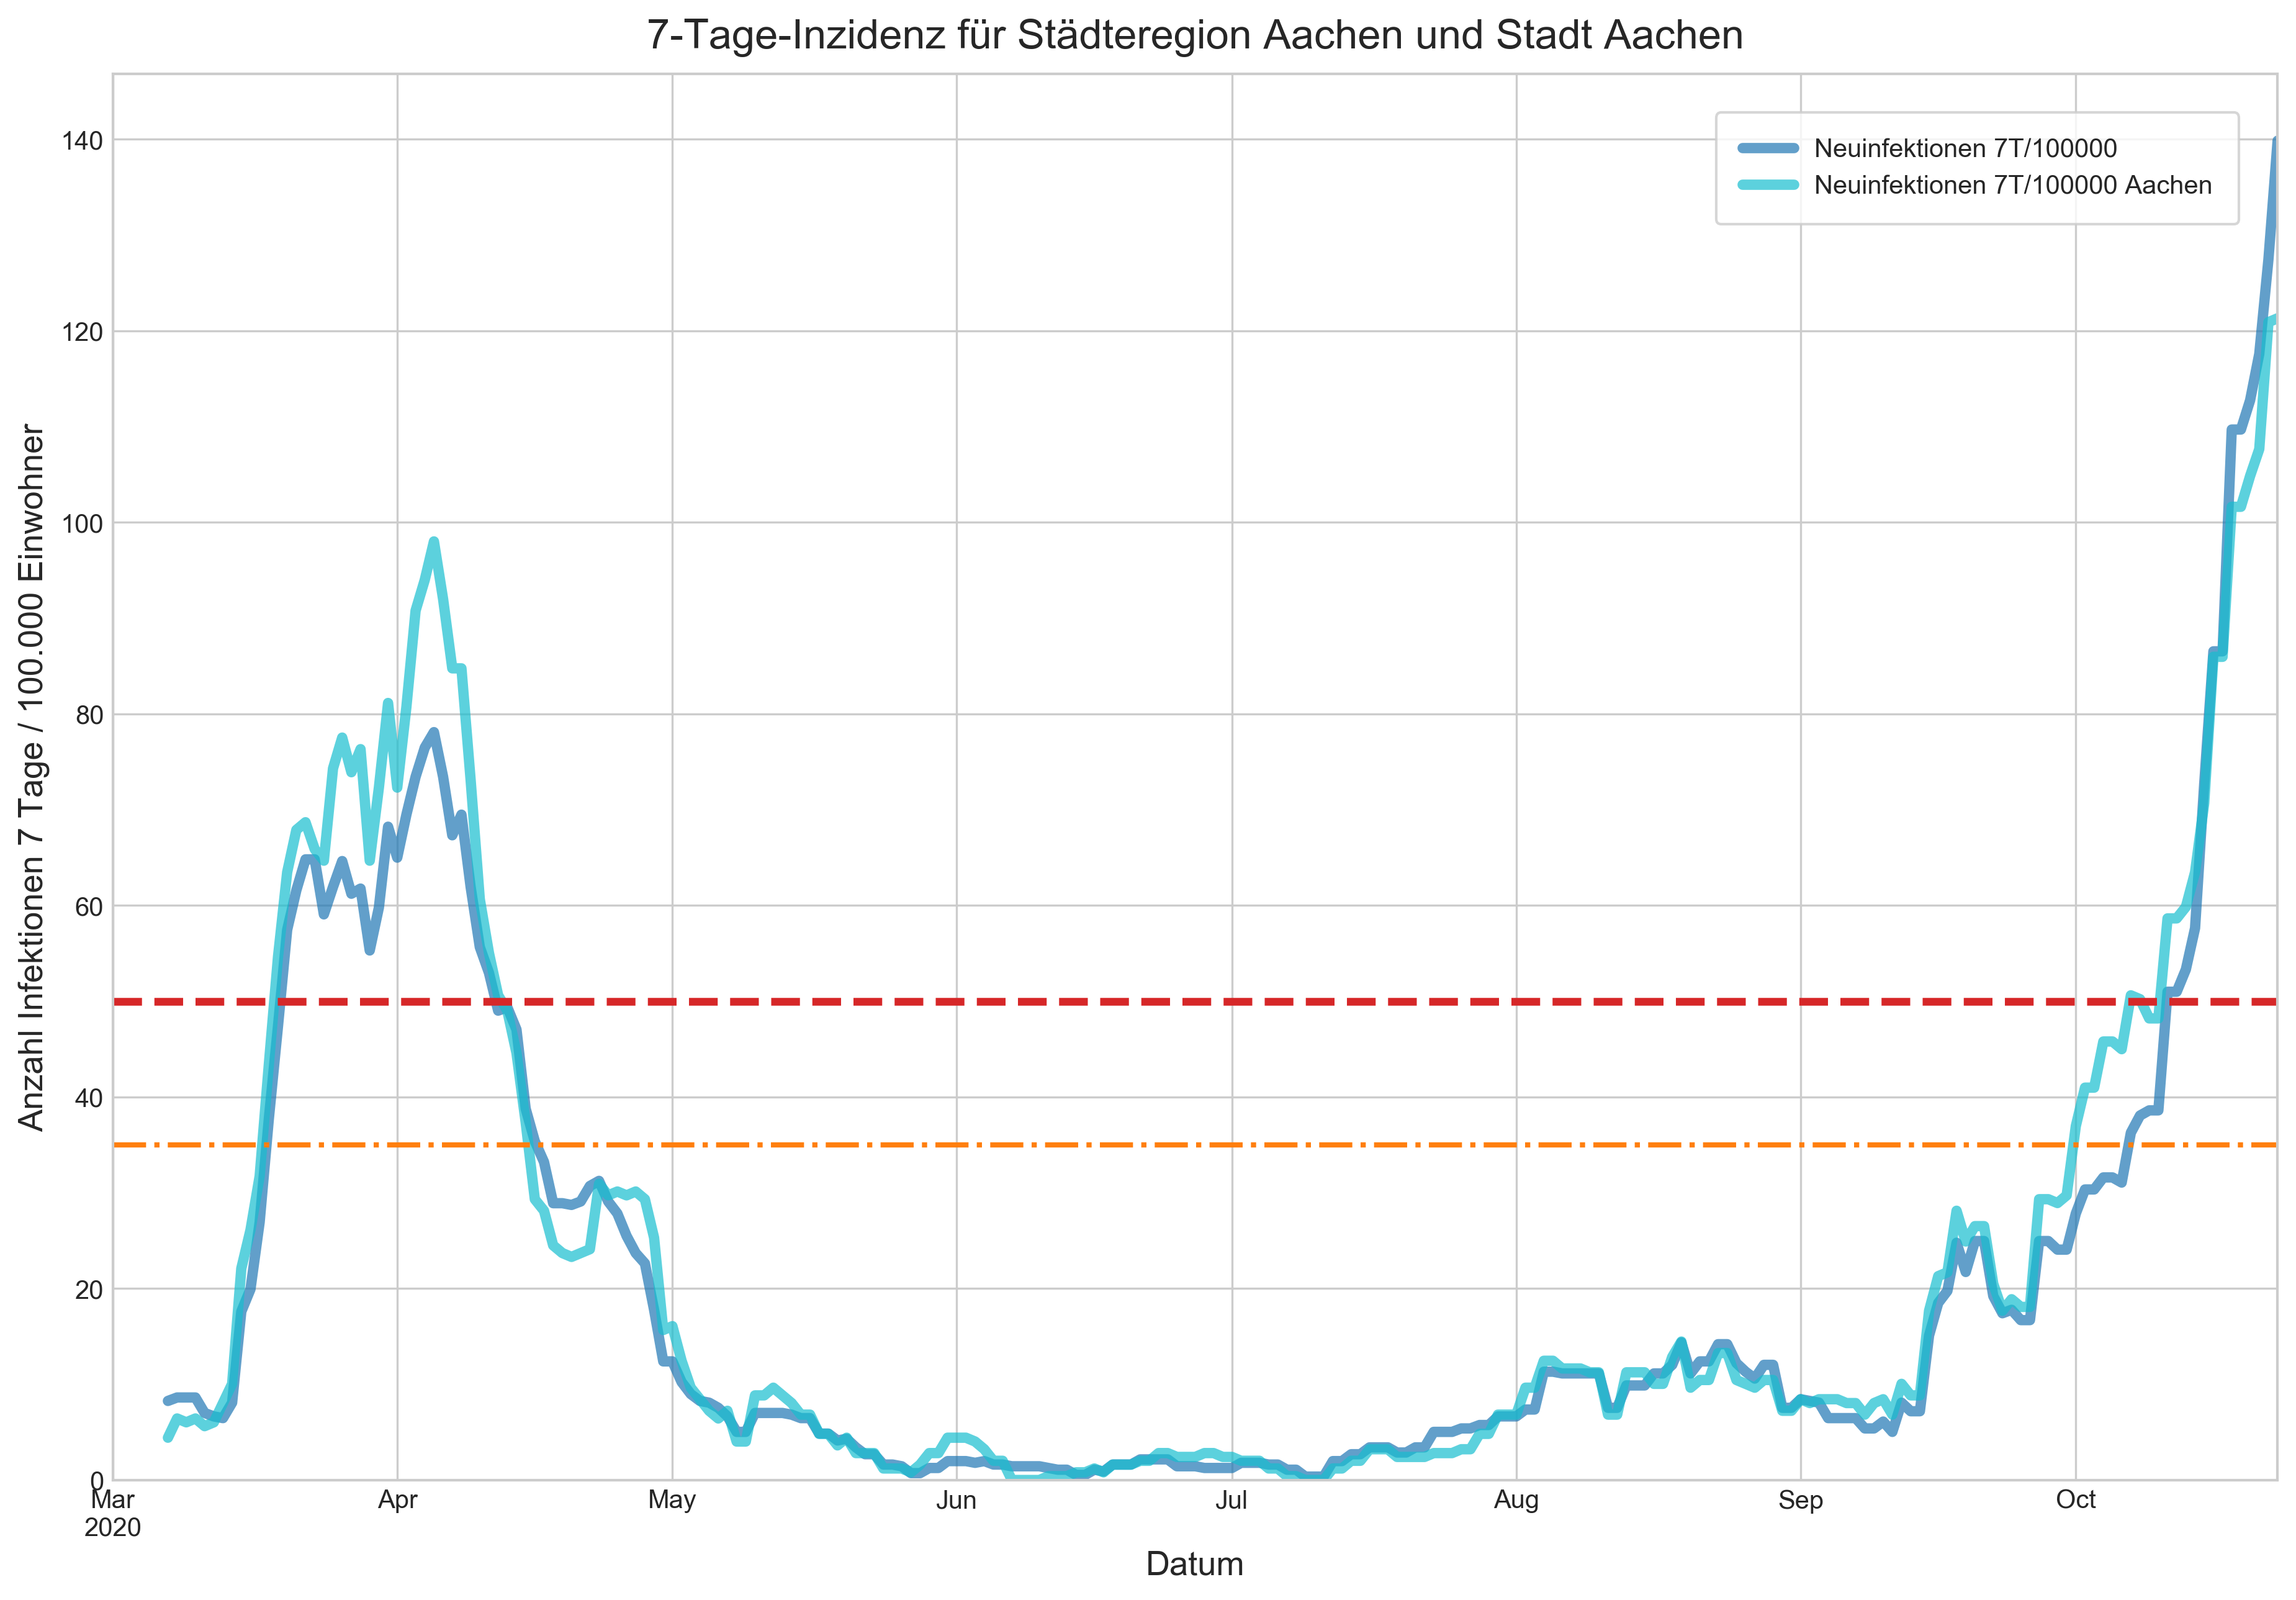

In [8]:
title = '7-Tage-Inzidenz für Städteregion Aachen und Stadt Aachen'

fig = plt.figure()
axes = fig.add_subplot(1,1,1)

# 1. Achse
ax1 = c19_cases[['Neuinfektionen 7T/100000', 'Neuinfektionen 7T/100000 Aachen']].plot.line(ax=axes, linewidth=4, alpha=0.7, color=["tab:blue", "tab:cyan"])

ax1.set_ylim(0,)
ax1.set_xlim(c19_cases.index[0], c19_cases.index[-1])
ax1.set_ylabel('Anzahl Infektionen 7 Tage / 100.000 Einwohner')

axes.set_title(title)
axes.axhline(y=50, ls='--', color='tab:red', linewidth=3)
axes.axhline(y=35, ls='-.', color='tab:orange', linewidth=2)
axes.legend(loc='best')
axes.grid(b=True, which='major', axis='both')
axes.set_xlabel('Datum')

fig.savefig(os.path.join(output_folder, 'c19-kennzahlen-ac-4.jpg'))
file_meta = { "title" : title, "caption": title }
create_meta_file(os.path.join(output_folder, 'c19-kennzahlen-ac-4.jpg.txt'), file_meta)